In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import matplotlib

matplotlib.rcParams.update({'font.size': 14})



In [2]:
# define the parameters to clean up the arrays
N_polymers = 50
N_steps = 500
# steps to skip to reach equilibirum
step_eq = 20
# steps to get uncorrelated samples
step_skip = 10
# chain cut
F = 1/2
# number of beads
Re = 1.0
N = 64
L = 2*Re

In [3]:
def calculate_mean_displacement(polymers_chains):
    # calculate the displacement as a function of the montecarlo step
    # args-> polymers_chains: array, contains the x,y,z coordinates of the desired point as  a function of
    #       montecarlo step for each polymer in the format [step, coordinate, polymer]
    # returns -> displacements_mean: array, average accros polymers of the displacement
    
    displacements = []
    i=1
    # iterate over montecarlo steps
    for i in range(0,len(polymers_chains)):
        # displacement vector for all polymers
        disp_vector = polymers_chains[i,:,:] - polymers_chains[0,:,:]         
        # calcualte the magnitude of the displacement for all polymers
        displacements.append( np.sum(disp_vector*disp_vector, axis=0) )
        
    # calculcate the mean with format [steps, polymers], 
    displacements_mean = np.mean(displacements, axis=1)
    
    return displacements_mean


def clean_polymers(coord_polymer):
    # cleans the coordinates of the polymers cm / junction point positions
    coord_list = []
    for i in range(0,N_polymers):
        # takes samples far appart from each other "start:end:step" step_skip
        coord_list.append(coord_polymer[i*N_steps:(i+1)*N_steps])
    # stack the list into a 3d array
    # the format is [montecarlo step, spatial dimension, polymer]

    coord_array = np.dstack(coord_list)
    print(np.shape(coord_array))
    # remember to skip the first step_eq montecarlo steps to take only at equilibrium and skip some of the
    # samples to get uncorrelated ones
    coord_clean = coord_array[step_eq:-1:step_skip,:,:].copy()
    print(np.shape(coord_clean))
    
    return coord_clean

## Analysis without fields

In [4]:
id_string = 'no_fields'

In [5]:

acceptance_ratios = np.loadtxt(id_string+'/acceptance_ratio.csv', delimiter=',')
delta_u_list = np.loadtxt(id_string+'/energy_changes.csv', delimiter=',')
u_list = np.loadtxt(id_string+'/energy_convergence.csv', delimiter=',')

montecarlo_chains = pd.read_pickle(id_string+'/montecarlo_chains.pkl')

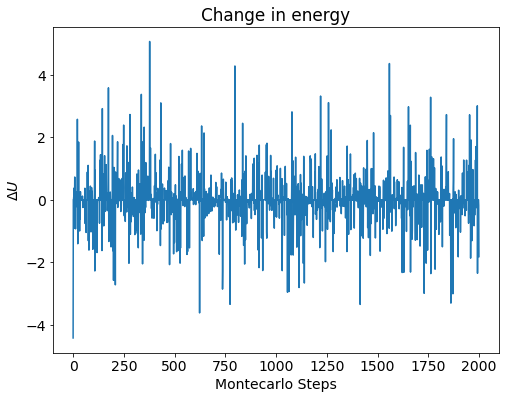

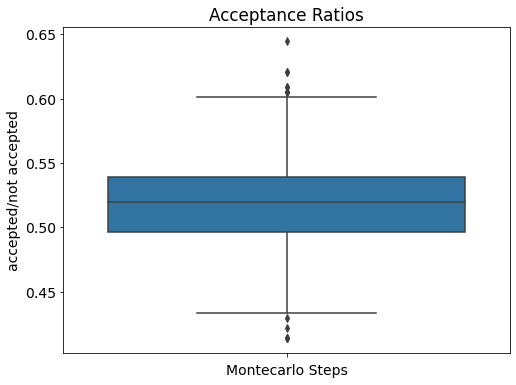

In [6]:
plt.figure(figsize=(8,6))
plt.plot(delta_u_list)
plt.title("Change in energy")
plt.xlabel("Montecarlo Steps")
plt.ylabel("$\Delta U$")


plt.figure(figsize=(8,6))
sns.boxplot(y=acceptance_ratios)
plt.title("Acceptance Ratios")
plt.xlabel("Montecarlo Steps")
plt.ylabel("accepted/not accepted")
plt.savefig('acceptance_ratios.png')


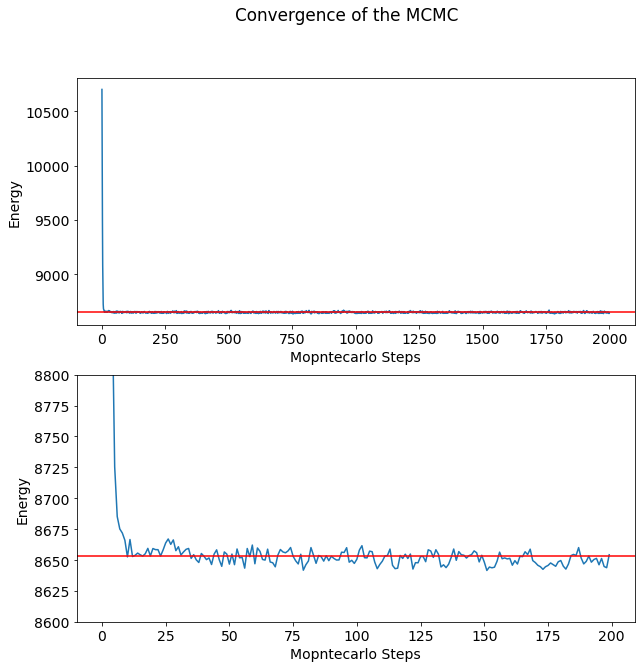

In [7]:

fig = plt.figure(figsize=(10,10))
plt.suptitle('Convergence of the MCMC')
plt.tight_layout()
plt.subplot(2,1,1)
plt.plot(u_list)
plt.axhline(np.mean(u_list), color ='r')
plt.xlabel('Mopntecarlo Steps')
plt.ylabel('Energy')


plt.subplot(2,1,2)
plt.plot(u_list[:200])
plt.axhline(np.mean(u_list), color ='r')
plt.ylim(8600,8800)
plt.xlabel('Mopntecarlo Steps')
plt.ylabel('Energy')
plt.savefig('energy_convergence.png')


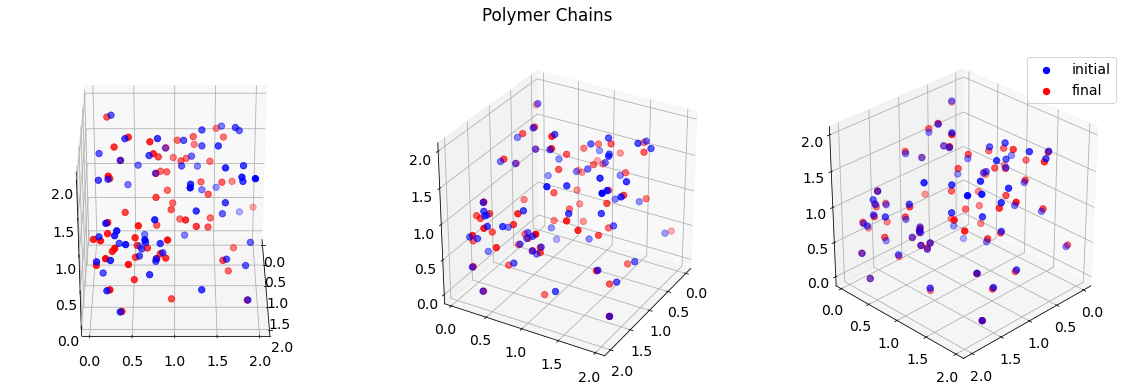

In [8]:
fig = plt.figure(figsize=(20,6))
plt.suptitle('Polymer Chains')
angles = [0, 30, 45]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(montecarlo_chains[0][:,0], montecarlo_chains[0][:,1], montecarlo_chains[0][:,2], 
                 c = 'blue', label='initial', s=40);
    ax.scatter3D(montecarlo_chains[-1][:,0], montecarlo_chains[-1][:,1], montecarlo_chains[-1][:,2], 
                 c='red', label='final', s=40);

    i+=1
    
plt.legend()
plt.savefig(id_string+'polymer.png')



In [9]:
# load data
cms = pd.read_pickle(id_string+'/center_masses.pkl')
cms = np.asarray(cms)

junction_p = pd.read_pickle(id_string+'/junction_points.pkl')
junction_p = np.asarray(junction_p)


(500, 3, 50)
(48, 3, 50)
(500, 3, 50)
(48, 3, 50)


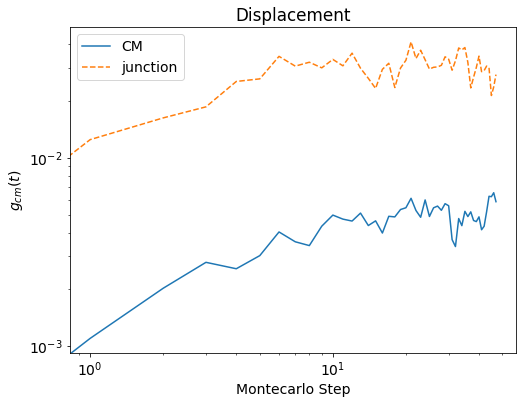

In [10]:
# calculate the center of mass displacement
cms_clean = clean_polymers(cms)
cm_displacement = calculate_mean_displacement(cms_clean)

# calcualte the junction displacement
junction_clean = clean_polymers(junction_p)
junction_displacement = calculate_mean_displacement(junction_clean)

plt.figure(figsize=(8,6))
plt.loglog(cm_displacement, label='CM')
plt.loglog(junction_displacement, linestyle='dashed', label='junction')

plt.ylabel('$g_{cm}(t)$')
plt.xlabel('Montecarlo Step')
plt.title('Displacement')
plt.legend()

plt.savefig(id_string+'_displacements.png')

# With fields


In [11]:
id_string = 'fields'

In [12]:
montecarlo_chains = pd.read_pickle(id_string+'/montecarlo_chains_polymers.pkl')

In [13]:
# load data
cms = pd.read_pickle(id_string+'/center_masses.pkl')
cms = np.asarray(cms)

junction_p = pd.read_pickle(id_string+'/junction_points.pkl')
junction_p = np.asarray(junction_p)


(500, 3, 50)
(48, 3, 50)
(500, 3, 50)
(48, 3, 50)


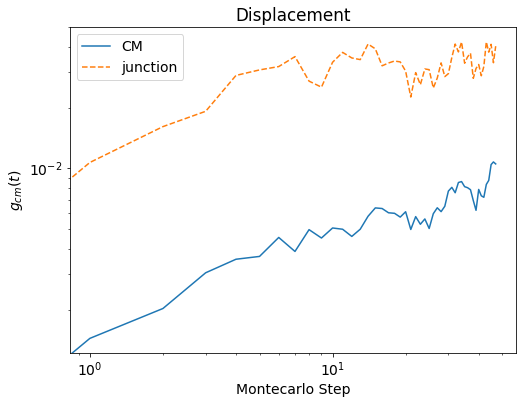

In [14]:
# calculate the center of mass displacement
cms_clean = clean_polymers(cms)
cm_displacement = calculate_mean_displacement(cms_clean)

# calcualte the junction displacement
junction_clean = clean_polymers(junction_p)
junction_displacement = calculate_mean_displacement(junction_clean)

plt.figure(figsize=(8,6))
plt.loglog(cm_displacement, label='CM')
plt.loglog(junction_displacement, linestyle='dashed', label='junction')

plt.ylabel('$g_{cm}(t)$')
plt.xlabel('Montecarlo Step')
plt.title('Displacement')
plt.legend()

plt.savefig(id_string+'_displacements.png')

In [20]:
chains_arr = np.dstack(montecarlo_chains)
A_polymers = chains_arr[:int(N*F),:,:]
B_polymers = chains_arr[int(N*F):,:,:]

# this is  not correct we have to sum the dirac delta average over each polymer and evaluate on all x's of the box
# maybe it is actally true
mean_A = (L/N)*np.mean(A_polymers,axis=2)
mean_B = (L/N)*np.mean(B_polymers,axis=2)

total_profile = mean_A + mean_A


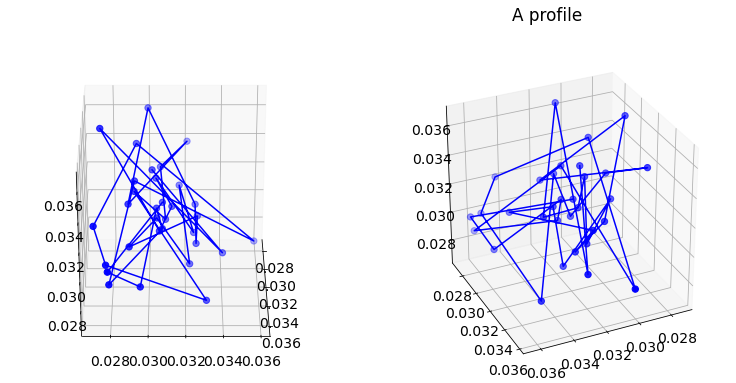

In [21]:
fig = plt.figure(figsize=(20,6))
plt.suptitle('A profile')
angles = [0 , 65]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(mean_A[:,0], mean_A[:,1], mean_A[:,2], 
                 c = 'blue', s=40);
    plt.plot(mean_A[:,0], mean_A[:,1], mean_A[:,2], 
                 c = 'blue')
    i+=1
    
plt.savefig(id_string+'_A_profile.png')

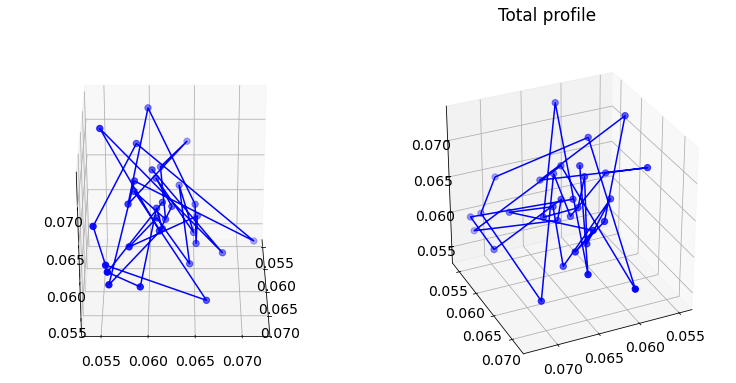

In [23]:
fig = plt.figure(figsize=(20,6))
plt.suptitle('Total profile')
angles = [0 , 65]
i = 1
# plot the first line
for angle in angles:
    # initial chain
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.view_init(azim=angle)
    ax.scatter3D(total_profile[:,0], total_profile[:,1], total_profile[:,2], 
                 c = 'blue', s=40);
    plt.plot(total_profile[:,0], total_profile[:,1], total_profile[:,2], 
                 c = 'blue')
    i+=1
    
plt.savefig(id_string+'_total_profile.png')